# Create $D^0$ candidates then $B$ candidates, and fit the $B$ mass peak

Make use of exclusive $B^\pm \to D^0 \pi^\pm$ sample created using EvtGen

In [3]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Load MC from `FCCAnalyses` output, where recontructed particles are stored in `RP` branches.

In [ ]:
mode = "Bu2D0Pi"
#path = loc.FLAT + f'/p8_ee_Zbb_ecm91_EvtGen_{mode}.root'
path = "/eos/experiment/fcc/ee/tmp/flatntuples/Z_Zbb_Flavor_Uproot_test3/p8_ee_Zbb_ecm91.root"
file = uproot.open(path)
tree = file['events']

#Number of events to keep and analyse
#n_events = 10000

#Container for the reco particles
p_c = 'RP'

events = tree.arrays(library="ak", how="zip", filter_name=f"{p_c}*")#[:n_events]

p = events[p_c]

Cut on the particle momenta

In [13]:
p_cut = p["p"] > 1.
p = p[p_cut]

Make pion and kaon samples based on track masses, then combine them into $D^0 \to K \pi$ candidates. Apply a cut around the $D^0$ mass.

In [14]:
pi_cut = abs(p["mass"] - lp.pi_plus.mass/1000.) < 1e-4
pi = p[pi_cut]

k_cut = abs(p["mass"] - lp.K_plus.mass/1000.) < 1e-4
k = p[k_cut]

D = ak.cartesian({"k": k, "pi": pi})
D_cut = np.sign(D["k","charge"]) != np.sign(D["pi","charge"])
D = D[D_cut]

PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
D["mass"] = kinematics_flat.mass([D["k"], D["pi"]], [PDG_K_m, PDG_pi_m])

PDG_D_m = lp.D_0.mass/1000.
D_window = 0.05
D_cut = abs(D["mass"] - PDG_D_m) < D_window
D = D[D_cut]

Make $B$ candidates by combining the $D^0$'s from above with pions.

In [15]:
B = ak.cartesian({"D": D, "pi": pi})
B_cut = np.sign(B["D","k","charge"]) == np.sign(B["pi","charge"])
B = B[B_cut]
B["mass"] = kinematics_flat.mass([B["D","k"], B["D","pi"], B["pi"]], [PDG_K_m, PDG_pi_m, PDG_pi_m])

Fit the $B$ mass distribution using `zfit`.

In [16]:
PDG_B_m = lp.B_plus.mass/1000.
B_window = 0.06
B_m_cut = abs(B["mass"] - PDG_B_m) < B_window
B = B[B_m_cut]
low = PDG_B_m - B_window
high = PDG_B_m + B_window
obs = zfit.Space('mB', limits=(low, high))

#Signal PDF
rand = random.randint(0,999)
B_mu = zfit.Parameter(f"B_mu_{rand}", PDG_B_m, low, high)
B_sigma = zfit.Parameter(f"B_sigma_{rand}", 0.004, 0., 0.1)
B_alphaL = zfit.Parameter(f"B_alphaL_{rand}", 0.2, 0., 5.)
B_nL = zfit.Parameter(f"B_nL_{rand}", 10., 0., 200.)
B_alphaR = zfit.Parameter(f"B_alphaR_{rand}", -0.2, -5., 0.)
B_nR = zfit.Parameter(f"B_nR_{rand}", 10., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.5, 0., 1.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaL, n=B_nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaR, n=B_nR)
pdf = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac)

Make dataset for `zfit`, passing in the mass values of the $B$ candidates.

In [17]:
data_np = ak.to_numpy(ak.flatten(B["mass"]))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [18]:
nll = zfit.loss.UnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit(tolerance=1e-5)
result = minimizer.minimize(nll)
param_errors, _ = result.errors(method="minuit_minos")

print("m(B) fit function minimum:", result.fmin)
print("m(B) fit converged:", result.converged)
print("m(B) fit full minimizer information:", result.info)

params = result.params
print(params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -2.323e+04                 │      Ncalls = 1471 (1471 total)      │
│ EDM = 8.98e-06 (Goal: 1e-05)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(B) fit function minimum: -23233.912381885028
m(B) fit converged: True
m(B) fit full minimizer information: {'n_eval': 1471, 'n_iter': 1471, 'original': FMin(fval=-23233.912381885028, edm=8.98304215081111e-06, tolerance=0.01, nfcn=1471, nc

Plot the fit result and MC $B$ peak.

/usr/local/bin/start_ipykernel.py:2: UserWarning: The function <function Space.limits at 0x7f127cd4a8c0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('mB',), axes=None, limits=(array([[5.21934]]), array([[5.33934]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  if __name__ == '__main__':
/usr/local/bin/start_ipykernel.py:13: UserWarning: The function <function Space.area at 0x7f127cd4ecb0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('mB',), axes=None, limits=(array([[5.21934]]), array([[5.33934]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.


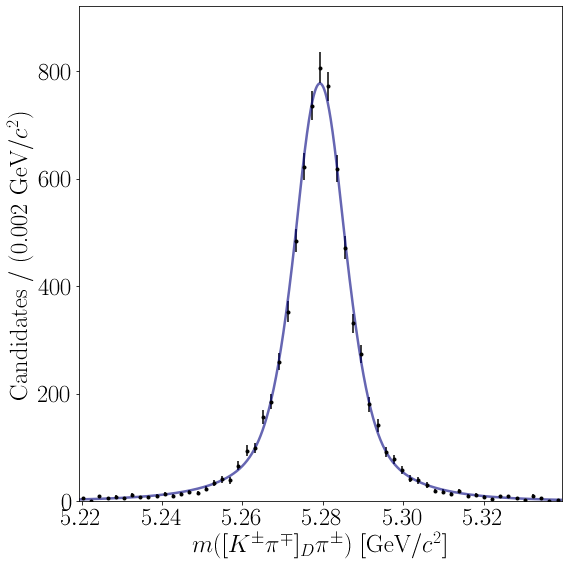

In [19]:
fig,ax = plt.subplots(figsize=(8,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.002
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m([K^\pm \pi^\mp]_D \pi^\pm)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{mode}_B_M_fit.pdf")